In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dictionary_new import category_product_dictionary
df = pd.read_csv("C:/Users/Pc_User/Desktop/H-Farm/fully_categorized_dataframe_v3.csv")
df['date'] = pd.to_datetime(df['date'])
df.drop('Unnamed: 0', axis=1, inplace=True)

In [2]:
health_categories = ['Contains plastic', 'Very Salty', 'Junk', 'Raffinato', 'Fruit', 'Vegetable', 'Alcohol', 
                     'Ready to eat/drink', 'Snacks', 'High in sugar', 'Condimenti', 'Cook', 'Integrale', 'Egg', 'Fish',
                    'White meat', 'Red meat', 'Dairy']

### Multiply each item by the number of units purchased during that visit

In [3]:
df[list(category_product_dictionary.keys())] = df[list(category_product_dictionary.keys())].multiply(df["n_unit"], axis="index")

In [4]:
df[df['n_unit'] == 5].head(5)

,Alcohol,Carrefour product,Cereals,Clothes,Coffee,Condimenti,Contains plastic,Cook,Dairy,Discounts,...,Woman,_id,customer,date,day_of_year,desc,mall,month,n_unit,net_am
711,0,0,0,0,0,5,0,5,0,0,...,0,1165,77031428274,2016-01-14 18:35:00,14,caballa aceite sur,2,1,5,7.20
894,0,0,0,0,0,0,0,0,5,0,...,0,143,77037711999,2016-01-14 17:45:00,14,est coto crianza x 2,1,1,5,53.50
917,0,0,0,0,0,0,0,0,0,0,...,0,1219,77022760202,2016-01-14 20:25:00,14,john /west salmon,1,1,5,19.55
1001,0,0,0,0,0,0,5,5,0,0,...,0,159,77037711999,2016-01-14 19:41:00,14,pechuga de pollo 90,1,1,5,5.00
1718,0,0,0,0,0,0,0,0,0,0,...,0,1393,77082105322,2016-01-14 20:32:00,14,pan sin gluten 50,1,1,5,3.25


## Drop item with zero or negative price

In [5]:
print(f"The number of products with non positive price is {np.sum(df['net_am'] <= 0)}")

The number of products with non positive price is 37843


In [6]:
print(f"Which can be dropped as they make the {round(np.sum(df['net_am'] <= 0) / len(df), 3)} % of the dataset")

Which can be dropped as they make the 0.006 % of the dataset


In [7]:
df = df[df['net_am'] > 0]

In [8]:
df.shape

(5869280, 49)

## Preparing clustering and visualization functions

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

def DBSCAN_clustering(data, eps, min_s):
    db = DBSCAN(eps=eps, min_samples=min_s)
    labels = db.fit_predict(np.array(data))
    data['labels'] = np.squeeze(labels)
    
def K_means(data, number_of_clusters, one_dim=False):
    if one_dim:
        km = KMeans(n_clusters=number_of_clusters)
        labels = km.fit_predict(np.array(data).reshape(-1, 1))
        return np.squeeze(labels)
    else:
        km = KMeans(n_clusters=number_of_clusters)
        labels = km.fit_predict(np.array(data))
        data['labels'] = np.squeeze(labels)

def show_clusters_inpairs(data, categories_to_compare):
    sns.pairplot(data[categories_to_compare + ['labels']], hue='labels')

def visualize_hist(data):
    fig, ax = plt.subplots(5,4, figsize=((20,20)))
    i = 0
    for a in range(5):
        for b in range(4):
            if i == len(health_categories):
                break
            ax[a,b].hist(data[health_categories[i]])
            i+= 1


# Metric 1: Average consumption of each category across visits

In [10]:
#drop the customers without a loyalty card for the moment
df = df[df['customer'] != 'Unknown']
customer_purchase = df.groupby('customer')[list(category_product_dictionary.keys()) + ['net_am']].mean()

In [11]:
aliya = df.copy()
aliya['hour'] = aliya['date'].dt.hour
customer_aliya = aliya.groupby('customer')[list(category_product_dictionary.keys()) + ['net_am', 'hour', 'month', 'day_of_year']].mean()

## Cluster on non standardized data

C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


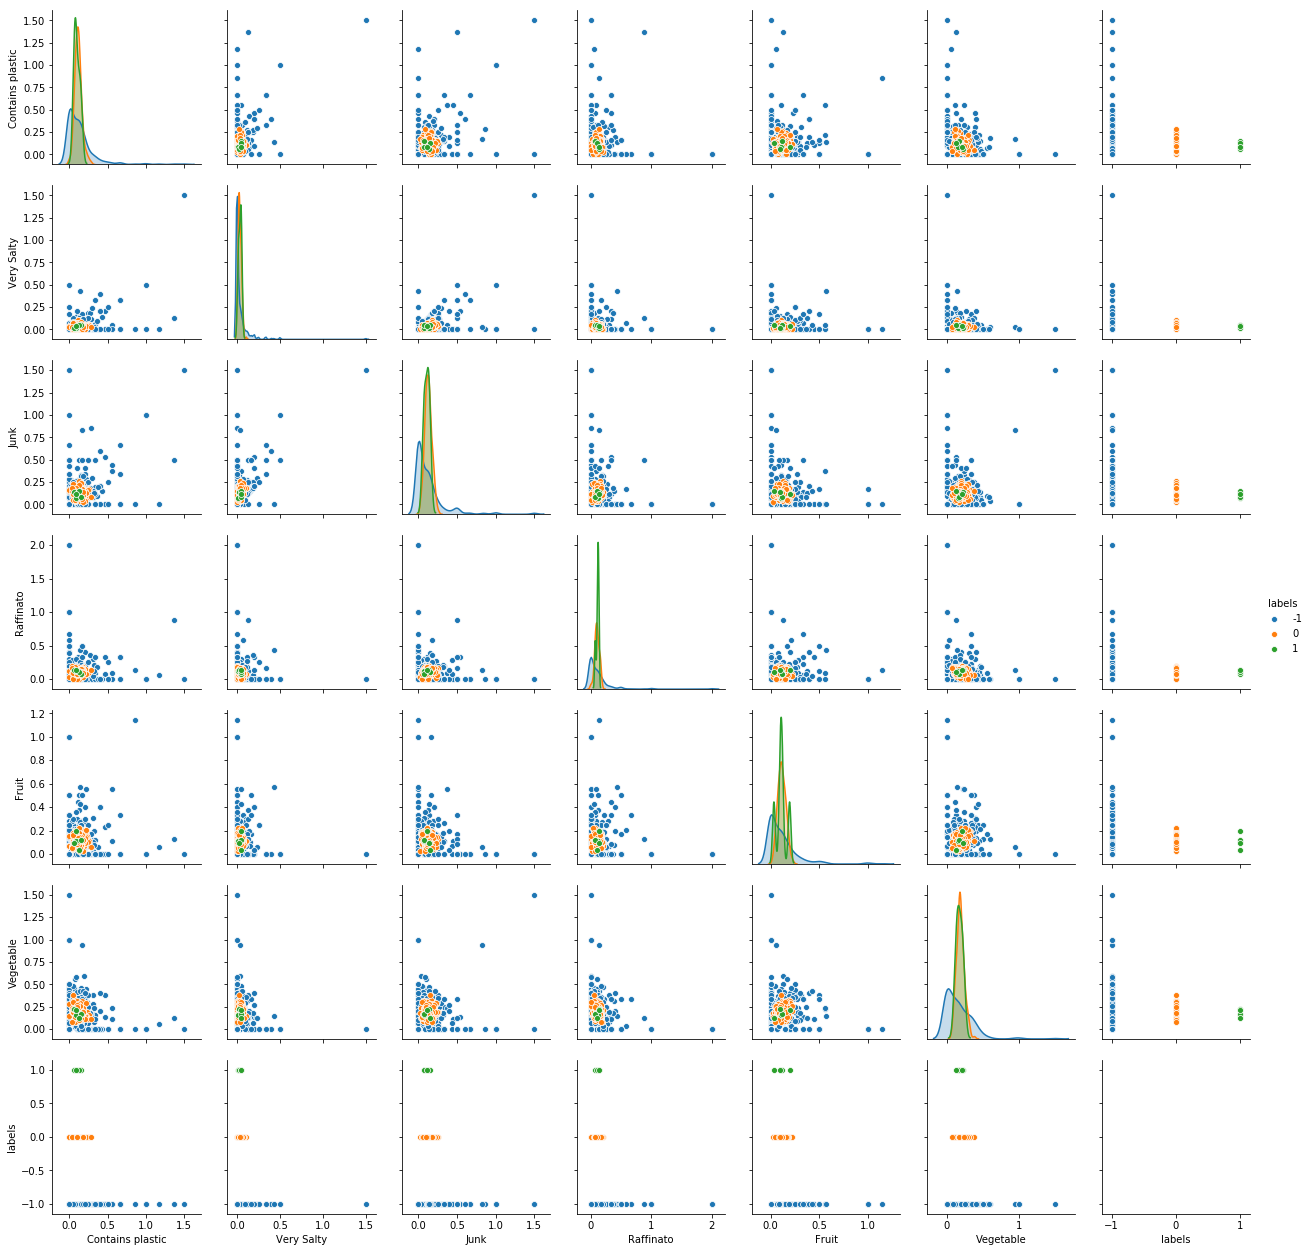

In [12]:
sample = customer_purchase.sample(500)
DBSCAN_clustering(sample, 0.3, 5)
show_clusters_inpairs(sample, health_categories[:6])

## Standardize the data

#### In this case it is necessary to normalize the data because of the following reason: say individual A buys on average 3 fruit items per visit and 3 "fatty" items, when on average individuals buy 5 fruit items and 3 "fatty". Well, if data are not standardized then you would assume that individual A consumes as much as fruit as fatty items on average, when it is not the case, if you take overall consumption of the two categories into account.

In [13]:
log_p = np.log(customer_purchase + 1)

In [14]:
log_p.describe()

,Carrefour product,Contains plastic,Very Salty,Junk,Raffinato,Fruit,Vegetable,Family product,Alcohol,Ready to eat/drink,...,House products,Clothes,Hygiene,For children,Medical,Woman,Plants,Discounts,Man,net_am
count,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,...,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000
mean,0.110236,0.113921,0.028161,0.107265,0.106262,0.100308,0.144742,0.036806,0.074202,0.050393,...,0.044546,0.009005,0.049603,0.005773,0.010904,0.005911,0.001291,0.000486,0.000936,1.441322
std,0.138029,0.132508,0.055032,0.118733,0.120016,0.109361,0.124422,0.069159,0.202658,0.097420,...,0.089574,0.047115,0.094673,0.043689,0.044400,0.036726,0.015606,0.011184,0.013434,0.398336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009950
25%,0.000000,0.031253,0.000000,0.000000,0.029742,0.000000,0.046520,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.264280
50%,0.089072,0.097164,0.012739,0.096730,0.093176,0.092373,0.146835,0.021979,0.000000,0.029632,...,0.023859,0.000000,0.025318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.419737
75%,0.149296,0.147636,0.037179,0.143101,0.133531,0.135802,0.200671,0.048790,0.072321,0.062132,...,0.057158,0.000000,0.062304,0.000000,0.008368,0.000000,0.000000,0.000000,0.000000,1.565060
max,3.610918,4.574711,1.791759,2.772589,2.525729,2.833213,2.104134,2.197225,5.820083,2.639057,...,3.526361,1.791759,2.233592,2.302585,1.845827,1.098612,1.791759,1.098612,0.916291,6.756932


In [15]:
stand_log = (log_p - log_p.mean())/log_p.std()

In [16]:
standardized_customer_avg=((customer_purchase-customer_purchase.mean())/customer_purchase.std())
standardized_customer_avg.head(5)

,Carrefour product,Contains plastic,Very Salty,Junk,Raffinato,Fruit,Vegetable,Family product,Alcohol,Ready to eat/drink,...,House products,Clothes,Hygiene,For children,Medical,Woman,Plants,Discounts,Man,net_am
customer,,,,,,,,,,,,,,,,,,,,,
77000001548,-0.191682,-0.093139,-0.310495,0.219504,-0.014485,-0.370813,-0.355535,-0.008358,-0.044529,0.420621,...,-0.168288,-0.150737,0.269637,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,-0.054270
77000001680,-0.081107,-0.132941,-0.094514,0.209697,-0.140537,-0.130816,0.195482,0.058119,-0.048802,-0.067564,...,0.052984,0.019054,0.152230,-0.087681,-0.123091,-0.133840,-0.054247,-0.035022,-0.058489,-0.071039
77000002166,-0.001607,-0.019211,-0.002800,-0.010908,0.120421,-0.101046,-0.141964,-0.048974,-0.030413,0.136097,...,-0.100886,-0.078214,-0.185044,-0.087681,-0.032240,-0.034288,0.132958,-0.035022,-0.058489,-0.156283
77000004744,-0.183192,-0.011492,0.263586,0.095997,-0.117036,-0.291282,0.427331,-0.310358,0.000315,-0.015666,...,-0.155799,-0.061649,-0.050695,-0.087681,-0.181223,-0.011550,-0.054247,-0.035022,-0.058489,-0.090189
77000005496,-0.420925,-0.261534,-0.420426,-0.614169,0.647642,0.769964,-0.942684,-0.365989,-0.068745,-0.355000,...,-0.243221,-0.150737,-0.395668,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,-0.094639


In [17]:
standardized_aliya = pd.concat([standardized_customer_avg, customer_aliya[['hour', 'month', 'day_of_year']]], axis=1)
assert len(standardized_aliya) == len(standardized_customer_avg)
standardized_aliya.head(5)

,Carrefour product,Contains plastic,Very Salty,Junk,Raffinato,Fruit,Vegetable,Family product,Alcohol,Ready to eat/drink,...,For children,Medical,Woman,Plants,Discounts,Man,net_am,hour,month,day_of_year
customer,,,,,,,,,,,,,,,,,,,,,
77000001548,-0.191682,-0.093139,-0.310495,0.219504,-0.014485,-0.370813,-0.355535,-0.008358,-0.044529,0.420621,...,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,-0.054270,21.000000,2.0,58.0
77000001680,-0.081107,-0.132941,-0.094514,0.209697,-0.140537,-0.130816,0.195482,0.058119,-0.048802,-0.067564,...,-0.087681,-0.123091,-0.133840,-0.054247,-0.035022,-0.058489,-0.071039,16.819608,1.0,22.0
77000002166,-0.001607,-0.019211,-0.002800,-0.010908,0.120421,-0.101046,-0.141964,-0.048974,-0.030413,0.136097,...,-0.087681,-0.032240,-0.034288,0.132958,-0.035022,-0.058489,-0.156283,19.020101,2.0,43.0
77000004744,-0.183192,-0.011492,0.263586,0.095997,-0.117036,-0.291282,0.427331,-0.310358,0.000315,-0.015666,...,-0.087681,-0.181223,-0.011550,-0.054247,-0.035022,-0.058489,-0.090189,11.685185,4.0,98.0
77000005496,-0.420925,-0.261534,-0.420426,-0.614169,0.647642,0.769964,-0.942684,-0.365989,-0.068745,-0.355000,...,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,-0.094639,23.000000,3.0,68.0


## Cluster on standardized data

C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Pc_User\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Pc_User\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Pc_U

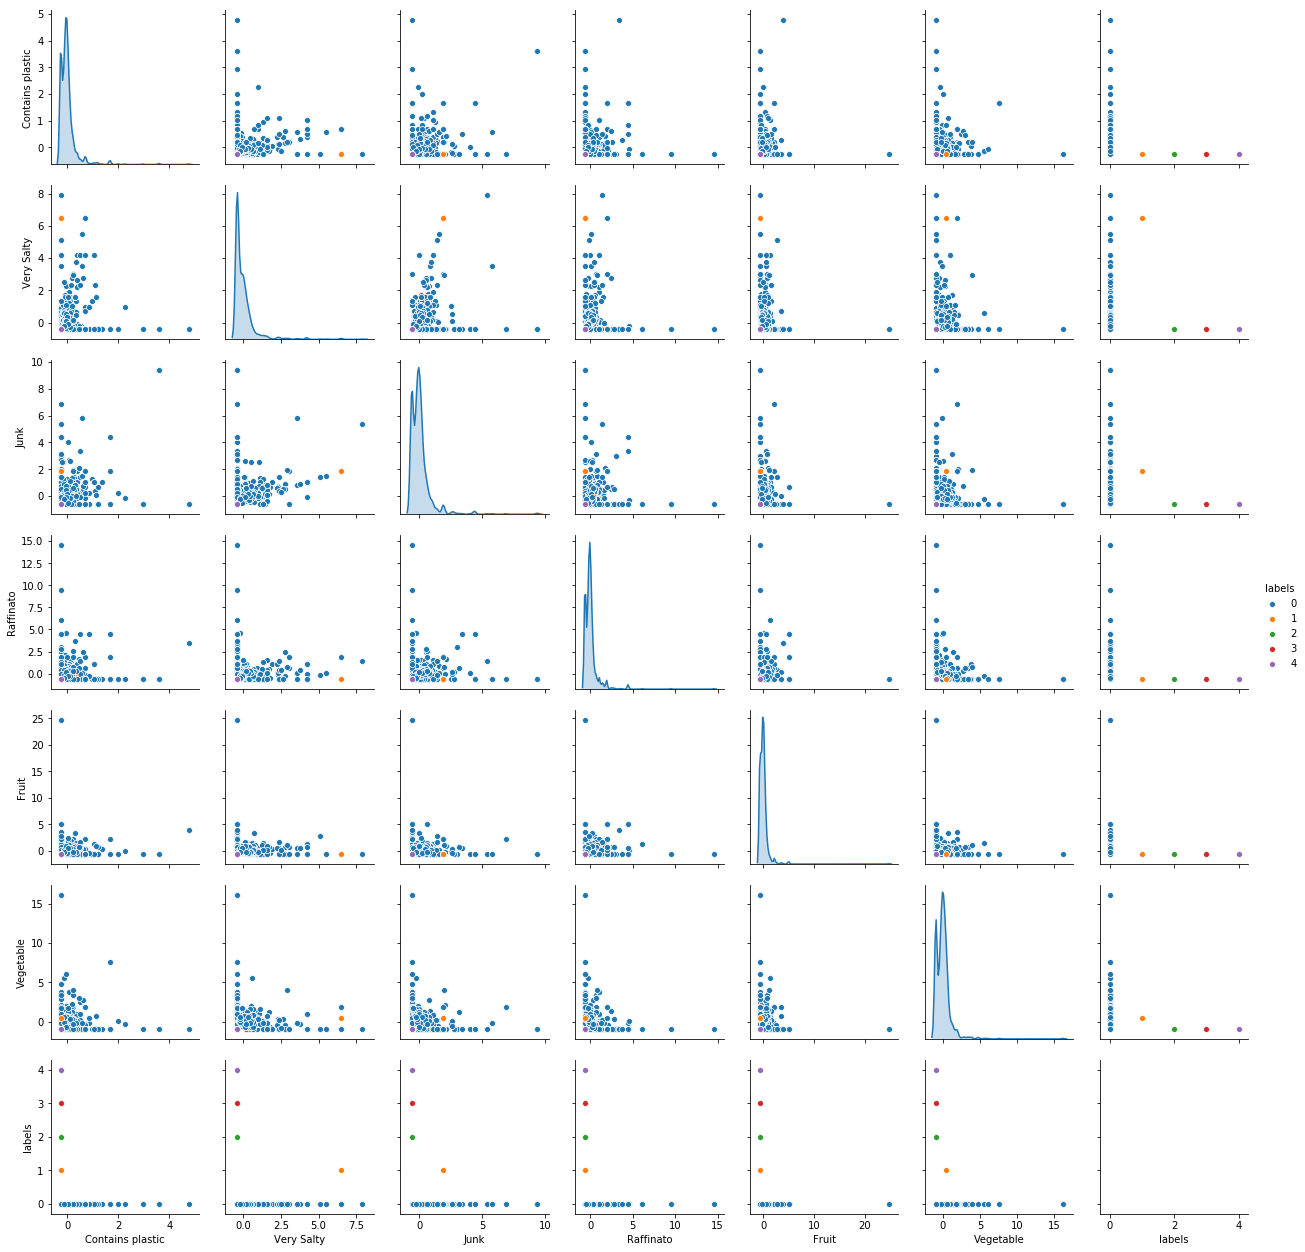

In [18]:
sample = standardized_customer_avg.sample(1000)
K_means(sample, number_of_clusters=5, one_dim=False)
show_clusters_inpairs(sample, health_categories[:6])

## Give a look at the distribution of the normalized proportion of each category in the bucket (highly skewed data)

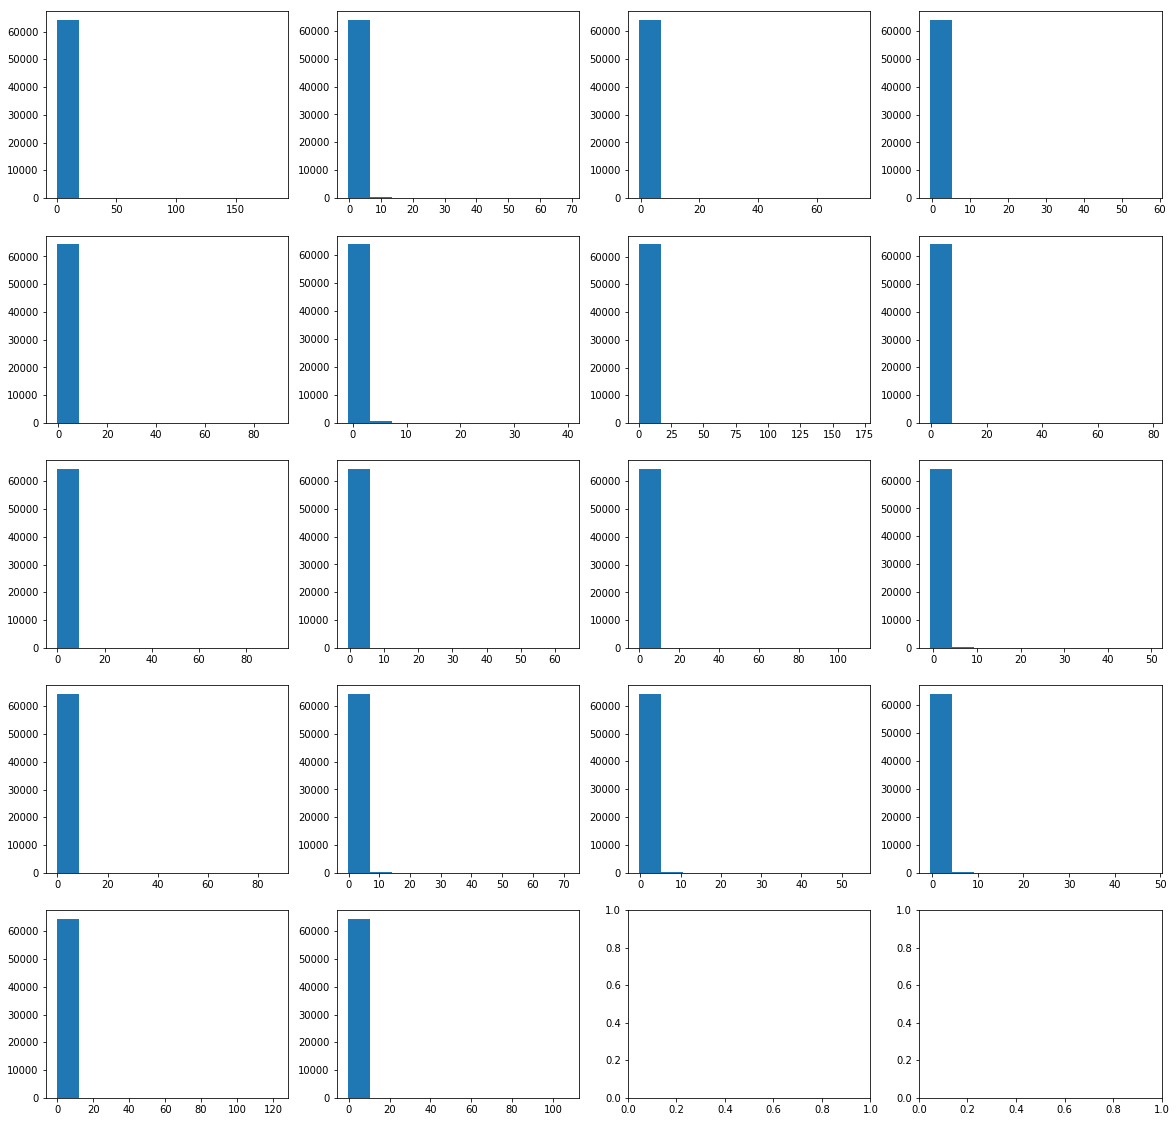

In [19]:
visualize_hist(standardized_customer_avg)

## Trimming

In [20]:
standardized_customer_avg[(standardized_customer_avg > 10).any(axis=1)].describe()

,Carrefour product,Contains plastic,Very Salty,Junk,Raffinato,Fruit,Vegetable,Family product,Alcohol,Ready to eat/drink,...,House products,Clothes,Hygiene,For children,Medical,Woman,Plants,Discounts,Man,net_am
count,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,...,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000
mean,0.537990,0.395908,0.329519,0.311271,0.485694,0.346701,-0.014465,0.257513,0.456468,0.706134,...,0.352046,0.788958,0.482456,0.724790,0.654821,0.823562,0.398634,0.512055,0.599439,0.967482
std,4.424111,5.006551,3.569335,3.800719,3.668643,3.885522,3.052743,3.989262,5.121663,4.070690,...,4.627697,4.301531,3.538559,4.882163,4.440981,4.417844,5.010473,5.141458,5.008074,4.847557
min,-0.420925,-0.261534,-0.420426,-0.614169,-0.616418,-0.639232,-0.942684,-0.365989,-0.068745,-0.355000,...,-0.243221,-0.150737,-0.395668,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,-0.435164
25%,-0.420925,-0.261534,-0.420426,-0.614169,-0.616418,-0.639232,-0.942684,-0.365989,-0.068745,-0.355000,...,-0.243221,-0.150737,-0.395668,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,-0.104613
50%,-0.420925,-0.261534,-0.420426,-0.614169,-0.616418,-0.639232,-0.942684,-0.365989,-0.068745,-0.355000,...,-0.243221,-0.150737,-0.395668,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,0.133612
75%,-0.420925,-0.261534,-0.420426,-0.614169,-0.616418,-0.639232,-0.942684,-0.365989,-0.068745,-0.355000,...,-0.243221,-0.150737,-0.395668,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,0.595243
max,115.117442,184.912043,68.835810,74.416450,57.530371,89.549302,40.031301,71.732377,170.796240,79.049250,...,155.542198,72.010342,57.818544,110.180008,78.879181,39.487822,186.214953,123.923575,83.878720,97.475099


## Eliminate those outliers for the moment

In [21]:
stand_log.describe()

,Carrefour product,Contains plastic,Very Salty,Junk,Raffinato,Fruit,Vegetable,Family product,Alcohol,Ready to eat/drink,...,House products,Clothes,Hygiene,For children,Medical,Woman,Plants,Discounts,Man,net_am
count,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,...,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04,6.437800e+04
mean,3.286375e-15,8.559116e-15,-1.928742e-14,-8.031227e-15,-5.303930e-15,-1.037963e-14,3.850508e-15,-2.351332e-14,-3.769246e-15,-1.287364e-14,...,-1.692473e-14,-1.122385e-15,-2.005977e-14,-1.254075e-15,6.194107e-15,2.096411e-15,7.985887e-16,-1.029300e-15,1.459932e-15,2.511996e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.986436e-01,-8.597337e-01,-5.117177e-01,-9.034140e-01,-8.854000e-01,-9.172185e-01,-1.163320e+00,-5.321955e-01,-3.661426e-01,-5.172729e-01,...,-4.973176e-01,-1.911271e-01,-5.239451e-01,-1.321487e-01,-2.455943e-01,-1.609635e-01,-8.272732e-02,-4.349568e-02,-6.971086e-02,-3.593375e+00
25%,-7.986436e-01,-6.238793e-01,-5.117177e-01,-9.034140e-01,-6.375826e-01,-9.172185e-01,-7.894298e-01,-5.321955e-01,-3.661426e-01,-5.172729e-01,...,-4.973176e-01,-1.911271e-01,-5.239451e-01,-1.321487e-01,-2.455943e-01,-1.609635e-01,-8.272732e-02,-4.349568e-02,-6.971086e-02,-4.444535e-01
50%,-1.533328e-01,-1.264655e-01,-2.802340e-01,-8.873300e-02,-1.090346e-01,-7.255368e-02,1.682397e-02,-2.143919e-01,-3.661426e-01,-2.131074e-01,...,-2.309515e-01,-1.911271e-01,-2.565212e-01,-1.321487e-01,-2.455943e-01,-1.609635e-01,-8.272732e-02,-4.349568e-02,-6.971086e-02,-5.418625e-02
75%,2.829834e-01,2.544348e-01,1.638703e-01,3.018170e-01,2.272114e-01,3.245555e-01,4.495089e-01,1.732850e-01,-9.281695e-03,1.204994e-01,...,1.407998e-01,-1.911271e-01,1.341510e-01,-1.321487e-01,-5.712025e-02,-1.609635e-01,-8.272732e-02,-4.349568e-02,-6.971086e-02,3.106392e-01
max,2.536186e+01,3.366436e+01,3.204674e+01,2.244802e+01,2.015950e+01,2.498978e+01,1.574801e+01,3.123854e+01,2.835262e+01,2.657221e+01,...,3.887103e+01,3.783835e+01,2.306878e+01,5.257168e+01,4.132706e+01,2.975307e+01,1.147315e+02,9.818493e+01,6.813963e+01,1.334453e+01


In [22]:
norm_noot_avg = standardized_customer_avg[(standardized_customer_avg < 5).all(axis=1)]
norm_noot_avg.describe()

,Carrefour product,Contains plastic,Very Salty,Junk,Raffinato,Fruit,Vegetable,Family product,Alcohol,Ready to eat/drink,...,House products,Clothes,Hygiene,For children,Medical,Woman,Plants,Discounts,Man,net_am
count,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,...,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000
mean,-0.031647,-0.023095,-0.023033,-0.017676,-0.031117,-0.004805,0.020029,-0.021808,-0.020493,-0.051561,...,-0.019077,-0.052127,-0.048646,-0.036367,-0.036326,-0.049849,-0.020473,-0.021679,-0.028031,-0.053681
std,0.432976,0.249035,0.605667,0.583911,0.595131,0.624177,0.762701,0.498322,0.169936,0.450000,...,0.391176,0.363387,0.542733,0.240562,0.400087,0.321737,0.209165,0.145291,0.201726,0.239151
min,-0.420925,-0.261534,-0.420426,-0.614169,-0.616418,-0.639232,-0.942684,-0.365989,-0.068745,-0.355000,...,-0.243221,-0.150737,-0.395668,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,-0.420346
25%,-0.302059,-0.160013,-0.420426,-0.375977,-0.340121,-0.394154,-0.431149,-0.365989,-0.068745,-0.355000,...,-0.243221,-0.150737,-0.395668,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,-0.145389
50%,-0.102435,-0.057862,-0.175271,-0.078236,-0.107969,-0.065999,0.005787,-0.125661,-0.061582,-0.144379,...,-0.102602,-0.150737,-0.179297,-0.087681,-0.181223,-0.133840,-0.054247,-0.035022,-0.058489,-0.081685
75%,0.098242,0.043028,0.128138,0.167400,0.105902,0.194032,0.336154,0.102182,-0.026948,0.046123,...,0.045070,-0.109384,0.066621,-0.087681,-0.037303,-0.133840,-0.054247,-0.035022,-0.058489,-0.017758
max,4.928073,4.974029,4.966170,4.888076,4.572883,4.997552,4.748147,4.851656,4.981692,4.989517,...,4.477549,4.845030,4.843611,4.813105,4.930441,4.818868,4.804949,4.923322,4.807436,4.835411


In [23]:
stand_log_u = stand_log[(stand_log < 0.3).all(axis=1)]
stand_log_u.describe()

,Carrefour product,Contains plastic,Very Salty,Junk,Raffinato,Fruit,Vegetable,Family product,Alcohol,Ready to eat/drink,...,House products,Clothes,Hygiene,For children,Medical,Woman,Plants,Discounts,Man,net_am
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,...,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,-0.070232,-0.121243,0.002158,0.003461,-0.093097,0.019895,0.088309,-0.065917,-0.077387,-0.057093,...,0.007538,-0.060487,-0.050973,-0.052080,-0.063202,-0.063765,-0.040740,-0.039237,-0.045821,-0.117722
std,0.211016,0.190097,0.169871,0.158166,0.172139,0.170499,0.160031,0.169773,0.158356,0.141479,...,0.148217,0.116031,0.172705,0.104028,0.140069,0.104331,0.095368,0.030887,0.069898,0.202804
min,-0.610456,-0.859734,-0.511718,-0.466427,-0.533778,-0.607222,-0.401833,-0.532196,-0.366143,-0.517273,...,-0.371169,-0.191127,-0.459734,-0.132149,-0.245594,-0.160964,-0.082727,-0.043496,-0.069711,-0.661556
25%,-0.212483,-0.246872,-0.130155,-0.107298,-0.201906,-0.097775,-0.005393,-0.182910,-0.204800,-0.148515,...,-0.114779,-0.191127,-0.175869,-0.132149,-0.168064,-0.160964,-0.082727,-0.043496,-0.069711,-0.254056
50%,-0.051642,-0.110009,0.029196,0.014393,-0.092060,0.039035,0.118208,-0.090851,-0.079728,-0.045659,...,0.007041,-0.075303,-0.055381,-0.132149,-0.092114,-0.085656,-0.082727,-0.043496,-0.069711,-0.127965
75%,0.086319,-0.007870,0.117035,0.134404,0.016014,0.144158,0.213943,0.057270,0.008077,0.040234,...,0.127031,0.021657,0.076727,0.018851,0.027527,0.006453,-0.082727,-0.043496,-0.069711,0.044401
max,0.298222,0.242052,0.296025,0.294015,0.294264,0.292639,0.297429,0.299038,0.286049,0.269585,...,0.298264,0.289452,0.278670,0.269423,0.289973,0.284206,0.280328,0.215293,0.296092,0.217355


## Reduce Skewness

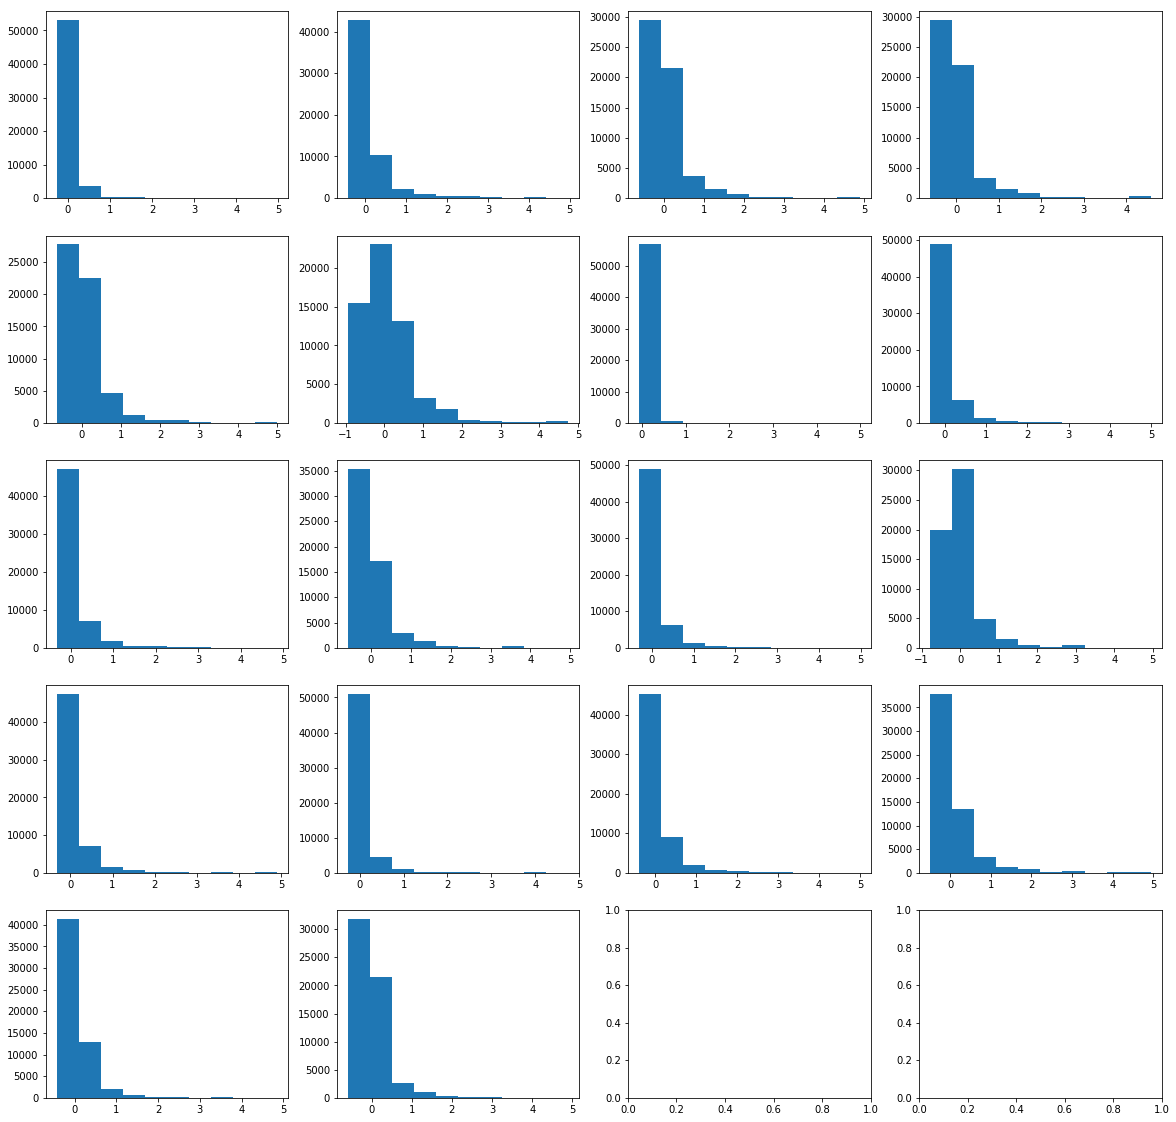

In [24]:
visualize_hist(norm_noot_avg)

In [25]:
cub_out_norm = np.cbrt(norm_noot_avg)
cub_out_norm.describe()

,Carrefour product,Contains plastic,Very Salty,Junk,Raffinato,Fruit,Vegetable,Family product,Alcohol,Ready to eat/drink,...,House products,Clothes,Hygiene,For children,Medical,Woman,Plants,Discounts,Man,net_am
count,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,...,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000,57665.000000
mean,-0.166491,-0.150057,-0.185534,-0.113010,-0.166795,-0.090852,-0.005734,-0.172887,-0.245946,-0.231642,...,-0.187710,-0.343050,-0.234779,-0.316513,-0.288947,-0.332027,-0.308620,-0.307649,-0.330825,-0.271298
std,0.605343,0.493007,0.674673,0.681113,0.657557,0.697700,0.772414,0.627729,0.313932,0.587916,...,0.540463,0.424036,0.628718,0.335805,0.494274,0.406123,0.269314,0.152877,0.252295,0.410028
min,-0.749437,-0.639503,-0.749140,-0.850020,-0.851057,-0.861429,-0.980518,-0.715302,-0.409650,-0.708070,...,-0.624214,-0.532198,-0.734137,-0.444258,-0.565898,-0.511519,-0.378553,-0.327175,-0.388173,-0.749093
25%,-0.670961,-0.542899,-0.749140,-0.721750,-0.698036,-0.733199,-0.755456,-0.715302,-0.409650,-0.708070,...,-0.624214,-0.532198,-0.734137,-0.444258,-0.565898,-0.511519,-0.378553,-0.327175,-0.388173,-0.525829
50%,-0.467897,-0.386781,-0.559633,-0.427697,-0.476175,-0.404123,0.179541,-0.500880,-0.394898,-0.524607,...,-0.468151,-0.532198,-0.563885,-0.444258,-0.565898,-0.511519,-0.378553,-0.327175,-0.388173,-0.433891
75%,0.461423,0.350416,0.504150,0.551127,0.473117,0.578928,0.695312,0.467511,-0.299807,0.358625,...,0.355875,-0.478246,0.405388,-0.444258,-0.334128,-0.511519,-0.378553,-0.327175,-0.388173,-0.260894
max,1.701737,1.707010,1.706111,1.697120,1.659829,1.709697,1.680769,1.692895,1.707886,1.708780,...,1.648213,1.692124,1.691959,1.688399,1.702009,1.689073,1.687445,1.701190,1.687736,1.691003


## Compare K-Means with DBSCAN, a partitioning algorithm against a clustering algorithm

### These representations clearly show the strenghts and weakness of each algorithm. When the data points are splittable by dividing the space K-Means performs much better, but when it comes to locate patterns DBSCAN is much more effective

#### K-Means good


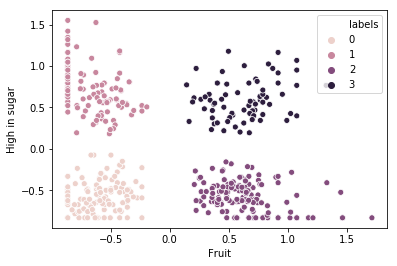

In [26]:
sample = cub_out_norm[['Fruit', 'High in sugar']].sample(500)
K_means(sample, number_of_clusters=4)
sns.scatterplot(x='Fruit', y = 'High in sugar', data=sample, hue='labels')

#### DBSCAN bad


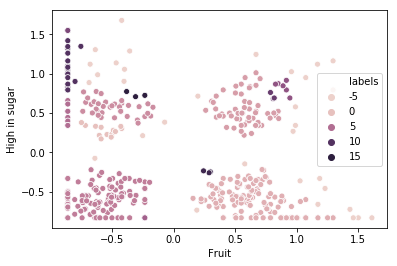

In [27]:
sample = cub_out_norm[['Fruit', 'High in sugar']].sample(500)
DBSCAN_clustering(sample, 0.11, 3)
sns.scatterplot(x='Fruit', y = 'High in sugar', data=sample, hue='labels')

### Change data

#### DBSCAN good

C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


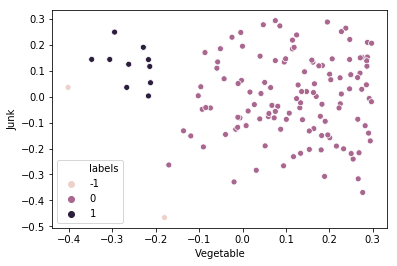

In [28]:
sample = stand_log_u[['Vegetable', 'Junk']]
DBSCAN_clustering(sample, 0.11, 3)
sns.scatterplot(x='Vegetable', y = 'Junk', data=sample, hue='labels')

#### K-Means bad

C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


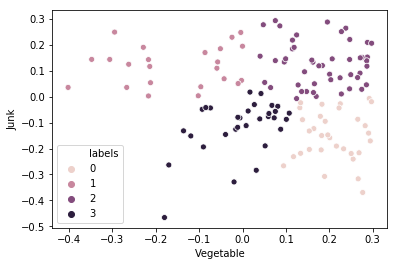

In [29]:
sample = stand_log_u[['Vegetable', 'Junk']]
K_means(sample, number_of_clusters=4)
sns.scatterplot(x='Vegetable', y = 'Junk', data=sample, hue='labels')

# General Clusters

In [30]:
attributes = pd.DataFrame()
income = pd.DataFrame()
plt.style.use('seaborn')

## "Income" distribution - based on the median 

In [31]:
income['Income Level'] = df.groupby('customer')['net_am'].median()
income['Constant'] = "0"

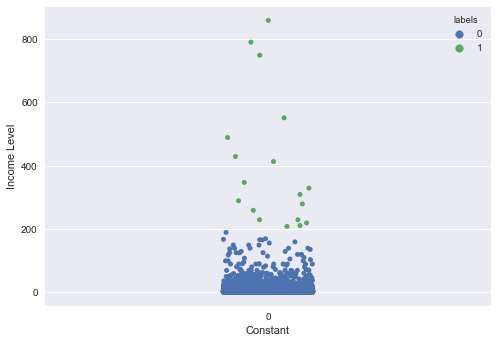

In [32]:
income['labels'] = K_means(data=income['Income Level'], number_of_clusters=2, one_dim=True)
sns.stripplot(x=income['Constant'], y=income['Income Level'] ,hue=income['labels'],jitter=True)

## How many customers are good cooks?

In [33]:
attributes['Cooking score'] = norm_noot_avg['Vegetable']
attributes['Constant'] = "0"

cooking_categories = ['Fish', 'White meat', 'Red meat', 'Legumes', 'Egg']
for category in cooking_categories:
    attributes['Cooking score'] += norm_noot_avg[category]
    if category == cooking_categories[len(cooking_categories) - 1]:
        attributes['Cooking score'] = attributes['Cooking score'].multiply(norm_noot_avg['Ready to eat/drink'].apply(lambda x: 0 if x > 0 else 1)) 

In [34]:
attributes['labels'] = K_means(data=attributes['Cooking score'], number_of_clusters=3, one_dim=True)

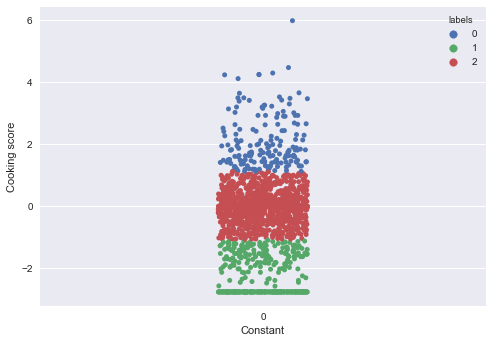

In [35]:
sample = attributes.sample(2000)
sns.stripplot(x=sample['Constant'], y=sample['Cooking score'] ,hue=sample['labels'],jitter=True)

## How many customers do have a family?

In [36]:
attributes['Family score'] = norm_noot_avg['For children'] + norm_noot_avg['Family product']
attributes['labels'] = K_means(data=attributes['Family score'], number_of_clusters=3, one_dim=True)

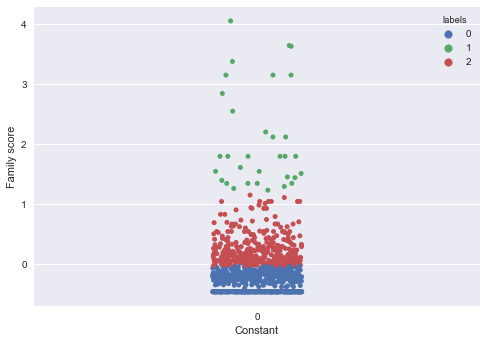

In [37]:
sample = attributes.sample(1000)
sns.stripplot(x=sample['Constant'], y=sample['Family score'], hue=sample['labels'],jitter=True)

## How many customers do have a baby

In [38]:
attributes['Baby score'] = norm_noot_avg['For children']
attributes['labels'] = K_means(data=attributes['Baby score'], number_of_clusters=2, one_dim=True)


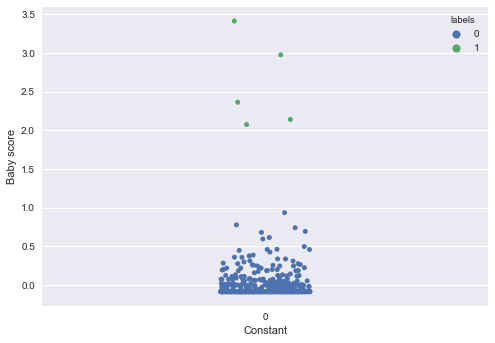

In [39]:
sample = attributes.sample(1000)
sns.stripplot(x=sample['Constant'], y=sample['Baby score'], hue=sample['labels'],jitter=True)

## How many customers are environmental friendly?

In [40]:
attributes['Env'] = norm_noot_avg['Contains plastic'].apply(lambda x: 1 if x < -3 else 0) + norm_noot_avg['One-time use product'].apply(lambda x: 1 if x < -3 else 0) + np.sqrt(norm_noot_avg['Packed in glass or aluminum'] + 5) 
attributes['labels'] = K_means(data=attributes['Env'], number_of_clusters=3, one_dim=True)

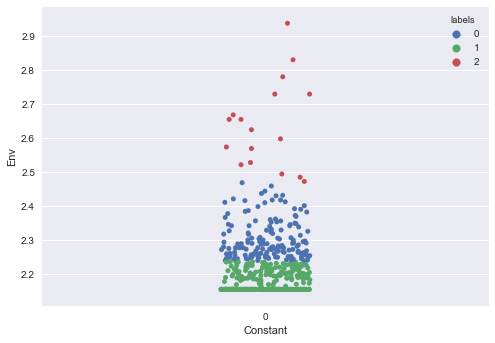

In [41]:
sample = attributes.sample(500)
sns.stripplot(x=sample['Constant'], y=sample['Env'] ,hue=sample['labels'],jitter=True)

## How healthy are customers?

In [42]:
health_categories = {'Fruit':[True, 1], 'Vegetable':[True, 1], 'Red meat':[False, 1], 'Fish':[True, 0.5], 
                     'Egg':[True, 0.5], 'Snacks':[False, 1], 'Junk':[False, 1], 'Ready to eat/drink':[False, 0.5], 
                     'Alcohol': [False, 1], 'Contains plastic':[False, 0.5]}

attributes['Healthy score'] = cub_out_norm['Fruit']
for cat in list(health_categories.keys())[1:]:
    if health_categories[cat][0]:
        attributes['Healthy score'] = attributes['Healthy score'] + health_categories[cat][1] * cub_out_norm[cat]
    else:
        attributes['Healthy score'] = attributes['Healthy score'] - health_categories[cat][1] *cub_out_norm[cat]

attributes['labels'] = K_means(data=attributes['Healthy score'], number_of_clusters=3, one_dim=True)
sample = attributes.sample(500)

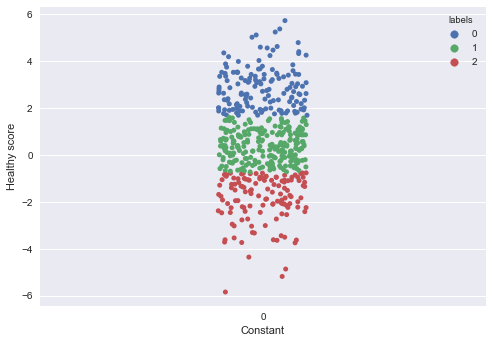

In [43]:
sns.stripplot(x=sample['Constant'], y=sample['Healthy score'] ,hue=sample['labels'],jitter=True, orient='v')

## Give a rough estimate of consumer age based on negative correlation between age and junk food / high in sugar food - set multiple categories

In [44]:
attributes['Age'] = (- norm_noot_avg['Junk'] - norm_noot_avg['High in sugar']) / 2

In [45]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler((20,50))
age = mm.fit_transform(np.array(attributes['Age']).reshape(-1, 1))
attributes['Age'] = age
attributes['labels'] = K_means(data=attributes['Age'], number_of_clusters=3, one_dim=True)


C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Inferred Age')

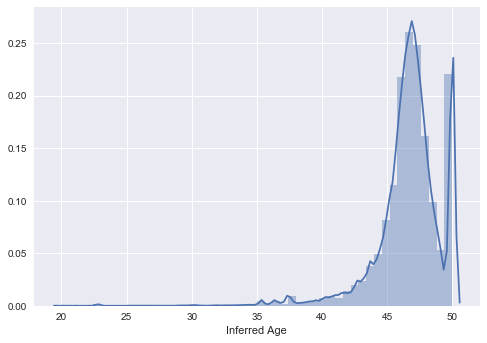

In [46]:
sns.distplot(age)
plt.xlabel('Inferred Age')

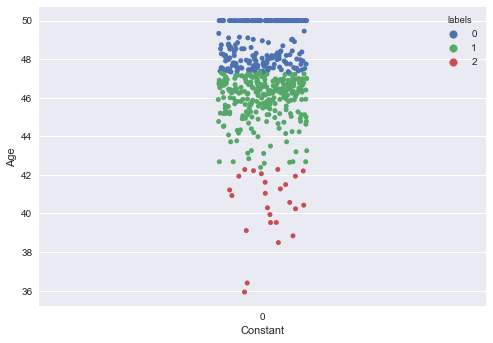

In [47]:
sample = attributes.sample(500)
sns.stripplot(x=sample['Constant'], y=sample['Age'] ,hue=sample['labels'],jitter=True)

## Dose the quantity of ready-to-eat food purchased increases if you are employed

In [48]:
variable_of_interest = 'Ready to eat/drink'

In [49]:
df['Hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.weekday + 1

In [50]:
emp = df.groupby('customer', as_index=False)[['Hour', 'weekday', variable_of_interest]].mean()

In [51]:
emp['Employed'] = emp.apply(lambda x: 1 if any([x['Hour'] >= 17, x['weekday'] >= 5]) else 0, axis=1)

In [52]:
np.sum(emp['Employed'])

43380

In [53]:
len(emp)

64378

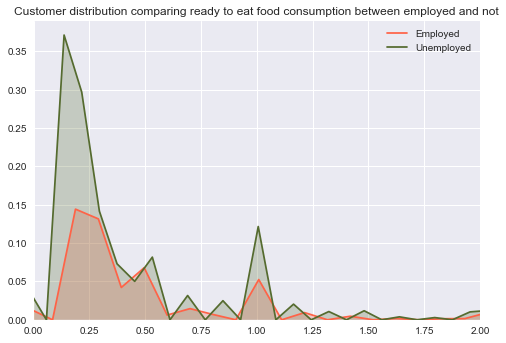

In [54]:
plt.style.use('seaborn')

fig, ax = plt.subplots()
ax = sns.kdeplot(emp.loc[emp['Employed'] == 1 , variable_of_interest],
            color='tomato',
            shade=True,
            Label='Employed')

ax = sns.kdeplot(emp.loc[emp['Employed'] == 0 , variable_of_interest],
            color='darkolivegreen',
            shade=True,
            Label='Unemployed')

_ = ax.set(title="Customer distribution comparing ready to eat food consumption between employed and not", xlim = (0,2))
ax.grid(True)

In [55]:
print(f"Average Ready to eat food consumption for Unemployed customer {np.mean(emp[variable_of_interest][emp['Employed'] == 0])}")
print(f"Average Ready to eat food consumption for Employed customer {np.mean(emp[variable_of_interest][emp['Employed'] == 1])}")

Average Ready to eat food consumption for Unemployed customer 0.06239676076027493
Average Ready to eat food consumption for Employed customer 0.05605034678260311


## How many customers have a car?

### See per each customer how many items he bought per visit

In [56]:
df.groupby(['customer', '_id'])['n_unit'].sum().head(20)

customer     _id   
77000001548  302872     9
             302873     4
             302875     3
             302877    22
             302879     7
             302880     7
             302883    15
             302884    23
             302886     3
             302887     4
             302888    11
             302889     9
             302890     2
             302891    75
             302893     2
             303872     1
77000001680  211393     3
             211394    36
             211395    51
             211396     7
Name: n_unit, dtype: int64

### Take the average number of items bought across visits per each customer

In [57]:
attributes['Average_n_items_bought'] = (df.groupby(['customer', '_id'], as_index=False)['n_unit'].sum()).groupby('customer')['n_unit'].mean()
attributes['Average_n_items_bought'].head(5)

customer
77000001548    12.312500
77000001680    19.222222
77000002166    16.166667
77000004744    30.375000
77000005496     4.000000
Name: Average_n_items_bought, dtype: float64

Text(0.5, 1.0, 'Distribution of the average number of items bought across visits per each customer')

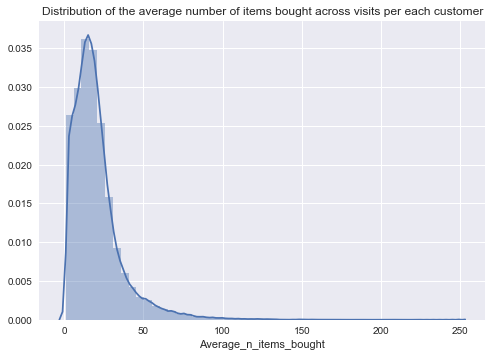

In [58]:
plt.style.use('seaborn')
sns.distplot(a=attributes['Average_n_items_bought'])
plt.grid(True)
plt.title("Distribution of the average number of items bought across visits per each customer")

### How many bought more than 30 items on average?

In [59]:
print(round(np.sum(attributes['Average_n_items_bought'] > 30) / len(attributes) * 100, 2), '%')

16.82 %


## How many customers have a pet?

Text(0.5, 0, 'Sum of pet products bought over all visits')

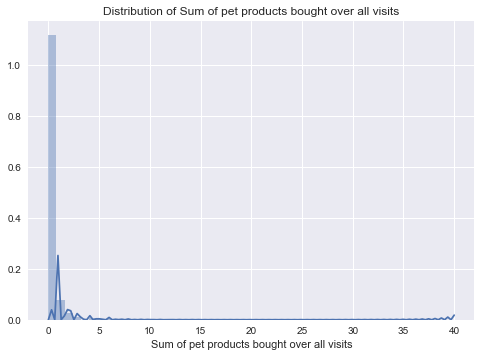

In [60]:
attributes['For pets'] = df.groupby(['customer'])['For pets'].sum()
sns.distplot(a=attributes['For pets'])
plt.grid(True)
plt.title("Distribution of Sum of pet products bought over all visits")
plt.xlabel('Sum of pet products bought over all visits')

In [61]:
print(round(np.sum(attributes['For pets'] > 0) / len(attributes) * 100, 2), '%')

10.48 %


## How many customers are vegan i.e. they did a lot of visits withot buying any meat, fish nor dairy products

In [62]:
summ = df.groupby('customer')[['White meat', 'Red meat', 'Fish','Egg', 'Dairy']].sum()
count = df.groupby('customer').size().to_frame('Number of visits')
vegan = pd.concat([summ, count], axis=1)
vegan.head(10)

,White meat,Red meat,Fish,Egg,Dairy,Number of visits
customer,,,,,,
77000001548,7,21,2,4,83,126
77000001680,2,32,22,6,91,255
77000002166,4,17,12,4,63,199
77000004744,8,24,25,1,37,162
77000005496,0,0,0,0,1,4
77000012658,0,0,0,0,0,1
77000013484,0,0,1,0,0,6
77000014989,0,0,1,0,0,1
77000016559,0,0,0,0,0,8


In [63]:
print(np.sum(np.all([np.all(vegan[['White meat', 'Red meat', 'Egg', 'Fish', 'Dairy']] == 0, axis=1), vegan['Number of visits'] > 5], axis=0)))

881


# Metric 2: Macronutrient composition -  a smart way to collapse dimensionality in 3 dimensions

### Everyi individual will be assigned with the average quantity of fat, carbs, and protein across his visits

* Take the most frequent product per category (use the mode as the estimator of the category)
* Assign the macronutrient composition of that product to that category
* Calculate the average consumption of fat, protein and carbs by taking the dot product between how much you consumed on average of a certain category and how much of each macronutrient that category contained


In [64]:
macros = pd.DataFrame(index=["Junk","Very Salty","Raffinato","Fruit","Vegetable","High in sugar","Egg","Fish","White meat","Red meat","Dairy","Legumes"], 
                       data={'Carbs' : [0.53,0.53,0.75,0.85,0.89,0.51,0.02,0,0,0,0.58,0.68],
                       'Proteins' : [0.04,0.04,0.11,0.07,0.06,0.04,0.38,0.06,0.8,0.5,0.02,0.3],
                       'Fat': [0.43,0.43,0.12,0.08,0.05,0.45,0.6,0.94,0.2,0.5,0.4,0.02]})

In [65]:
macros['Carbs']

Junk             0.53
Very Salty       0.53
Raffinato        0.75
Fruit            0.85
Vegetable        0.89
High in sugar    0.51
Egg              0.02
Fish             0.00
White meat       0.00
Red meat         0.00
Dairy            0.58
Legumes          0.68
Name: Carbs, dtype: float64

In [66]:
customer_purchase[list(macros.T.columns.values)].head(10)

,Junk,Very Salty,Raffinato,Fruit,Vegetable,High in sugar,Egg,Fish,White meat,Red meat,Dairy,Legumes
customer,,,,,,,,,,,,
77000001548,0.166667,0.007937,0.119048,0.047619,0.103175,0.071429,0.031746,0.015873,0.055556,0.166667,0.658730,0.015873
77000001680,0.164706,0.023529,0.094118,0.090196,0.200000,0.121569,0.023529,0.086275,0.007843,0.125490,0.356863,0.011765
77000002166,0.120603,0.030151,0.145729,0.095477,0.140704,0.135678,0.020101,0.060302,0.020101,0.085427,0.316583,0.000000
77000004744,0.141975,0.049383,0.098765,0.061728,0.240741,0.049383,0.006173,0.154321,0.049383,0.148148,0.228395,0.030864
77000005496,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
77000012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
77000013484,0.000000,0.000000,0.166667,0.166667,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000
77000014989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
77000016559,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Average carb in each category per customer given that he has consumed a certain amount of that category

In [67]:
customer_purchase[list(macros.T.columns.values)].multiply(macros['Carbs']).head(10)

,Junk,Very Salty,Raffinato,Fruit,Vegetable,High in sugar,Egg,Fish,White meat,Red meat,Dairy,Legumes
customer,,,,,,,,,,,,
77000001548,0.088333,0.004206,0.089286,0.040476,0.091825,0.036429,0.000635,0.0,0.0,0.0,0.382063,0.010794
77000001680,0.087294,0.012471,0.070588,0.076667,0.178000,0.062000,0.000471,0.0,0.0,0.0,0.206980,0.008000
77000002166,0.063920,0.015980,0.109296,0.081156,0.125226,0.069196,0.000402,0.0,0.0,0.0,0.183618,0.000000
77000004744,0.075247,0.026173,0.074074,0.052469,0.214259,0.025185,0.000123,0.0,0.0,0.0,0.132469,0.020988
77000005496,0.000000,0.000000,0.187500,0.212500,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.145000,0.000000
77000012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
77000013484,0.000000,0.000000,0.125000,0.141667,0.000000,0.085000,0.000000,0.0,0.0,0.0,0.000000,0.000000
77000014989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
77000016559,0.000000,0.000000,0.187500,0.212500,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [68]:
np.sum(customer_purchase[list(macros.T.columns.values)].multiply(macros['Carbs']), axis=1).head(10)

customer
77000001548    0.744048
77000001680    0.702471
77000002166    0.648794
77000004744    0.620988
77000005496    0.545000
77000012658    0.000000
77000013484    0.351667
77000014989    0.000000
77000016559    0.400000
77000018175    0.525098
dtype: float64

In [69]:
macros_customer = pd.DataFrame()
for nutrient in ['Carbs', 'Proteins', 'Fat']:
    macros_customer[nutrient] = np.cbrt(np.sum(norm_noot_avg[list(macros.T.columns.values)].multiply(macros[nutrient]), axis=1))

In [70]:
macros_customer.head(5)

,Carbs,Proteins,Fat
customer,,,
77000001548,-0.762163,0.620735,-0.444974
77000001680,0.203722,-0.683913,0.489728
77000002166,-0.666584,-0.701273,-0.536824
77000004744,0.549341,0.615030,0.792224
77000005496,-0.922298,-0.929664,-1.149115


Text(0.5, 0, 'Fat')

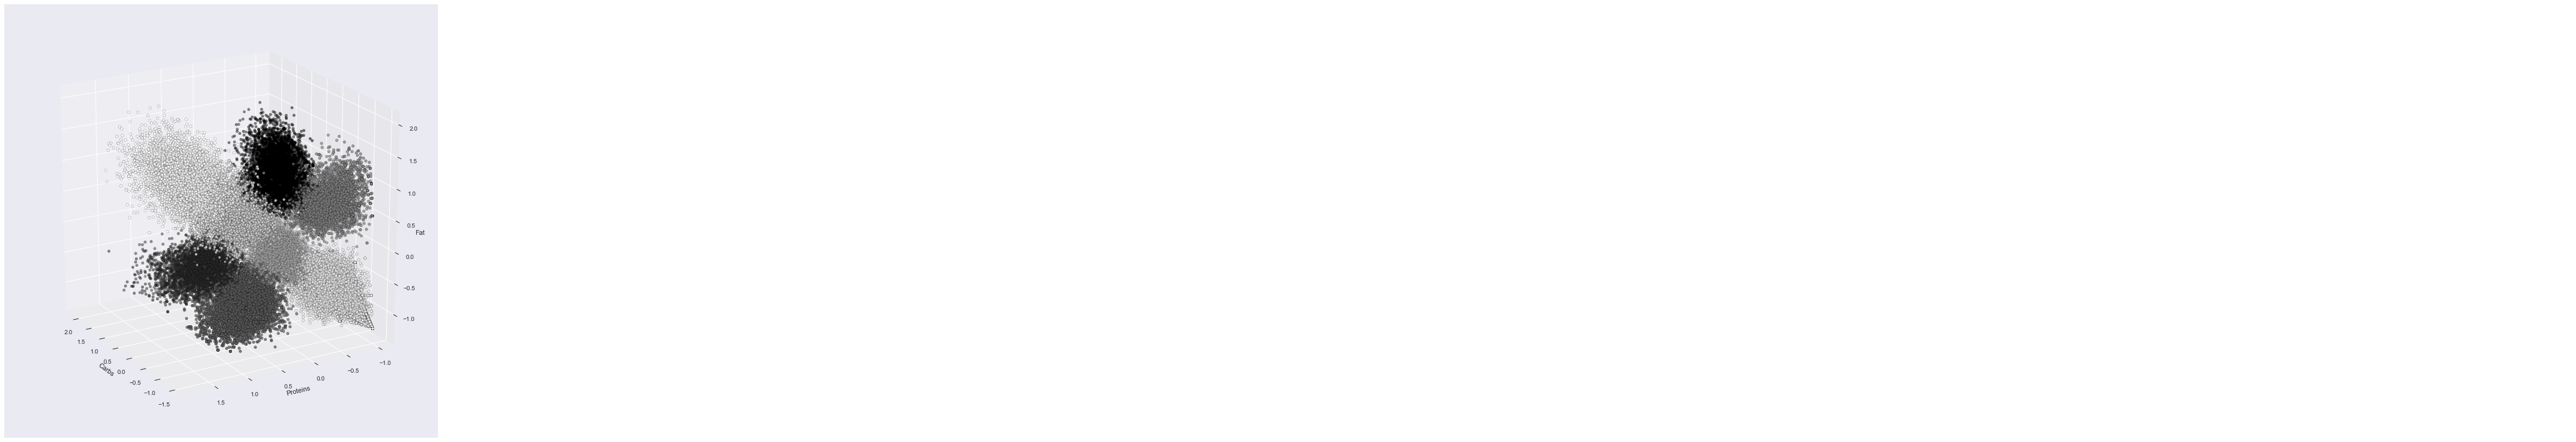

In [71]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(40,40))
ax = Axes3D(fig, rect=[0.15, 0.15, 0.25, 0.25], elev=20, azim=150)

K_means(macros_customer, number_of_clusters=8, one_dim=False)

ax.scatter(macros_customer['Carbs'], macros_customer['Proteins'], macros_customer['Fat'], 
           c = macros_customer['labels'], 
           edgecolor='k')

ax.set_xlabel('Carbs')
ax.set_ylabel('Proteins')
ax.set_zlabel('Fat')

# Focus cluster analysis on healthy/unhealthy

In [72]:
health_categories = ['Fruit', 'Vegetable', 'Red meat', 'Fish', 'Egg', 'Snacks', 'Junk', 'Ready to eat/drink', 'Alcohol',
                    'Contains plastic']

other_categories = list(set(standardized_aliya.columns.values).difference(set(health_categories)))
print(other_categories)

['Hygiene', 'month', 'Instruments to cook', 'Condimenti', 'Medical', 'One-time use product', 'hour', 'Carrefour product', 'Fitness products', 'Very Salty', 'Woman', 'Coffee', 'day_of_year', 'For pets', 'Cook', 'Cereals', 'Legumes', 'Drinks ', 'net_am', 'High in sugar', 'Integrale', 'House products', 'Dairy', 'Clothes', 'Plants', 'Packed in glass or aluminum', 'White meat', 'Raffinato', 'Family product', 'For children', 'Man', 'Discounts']


In [73]:
len(customer_purchase)

64378

In [74]:
customer_purchase[health_categories].describe()

,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Contains plastic
count,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000
mean,0.113404,0.165650,0.115353,0.057580,0.030622,0.032035,0.122784,0.058120,0.135184,0.135588
std,0.177406,0.175721,0.268849,0.145972,0.113707,0.096300,0.199918,0.163719,1.966465,0.518432
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031746
50%,0.096774,0.158163,0.095238,0.031982,0.010638,0.009346,0.101562,0.030075,0.000000,0.102041
75%,0.145455,0.222222,0.145833,0.070119,0.032609,0.038336,0.153846,0.064103,0.075000,0.159091
max,16.000000,7.200000,33.000000,8.000000,8.166667,9.000000,15.000000,13.000000,336.000000,96.000000


### Logarithm transformation

In [75]:
log = np.log(customer_purchase[health_categories] + 1)
log.describe()

,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Contains plastic
count,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000,64378.000000
mean,0.100308,0.144742,0.100578,0.050922,0.027187,0.029105,0.107265,0.050393,0.074202,0.113921
std,0.109361,0.124422,0.114701,0.089638,0.067346,0.062726,0.118733,0.097420,0.202658,0.132508
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.046520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031253
50%,0.092373,0.146835,0.090972,0.031481,0.010582,0.009302,0.096730,0.029632,0.000000,0.097164
75%,0.135802,0.200671,0.136132,0.067770,0.032088,0.037619,0.143101,0.062132,0.072321,0.147636
max,2.833213,2.104134,3.526361,2.197225,2.215574,2.302585,2.772589,2.639057,5.820083,4.574711


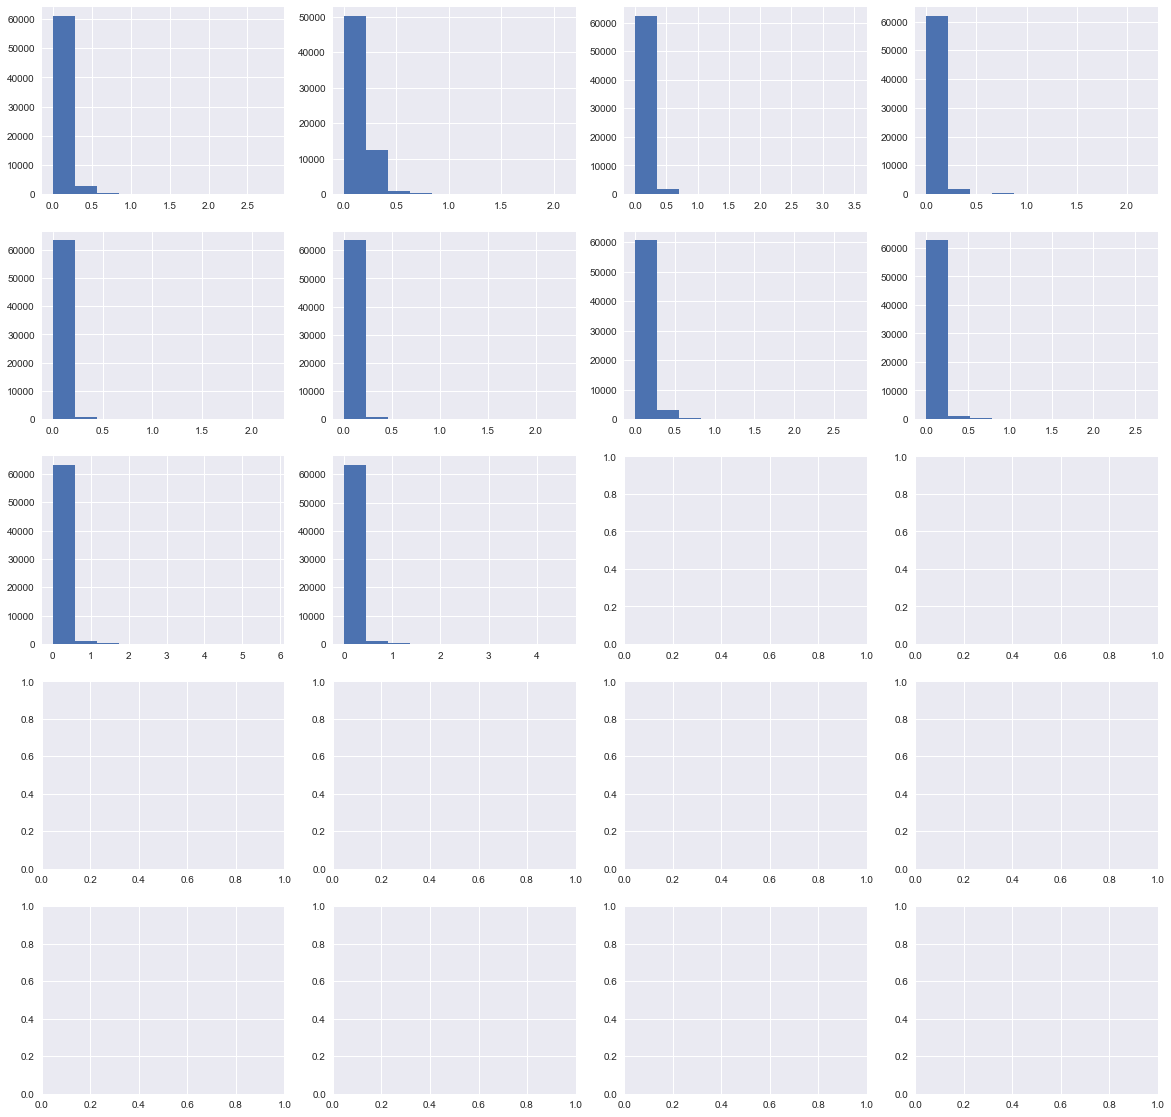

In [76]:
visualize_hist(log)

### Outlier elimination

In [77]:
out = np.sqrt(log[(log < 0.5).all(axis=1)])

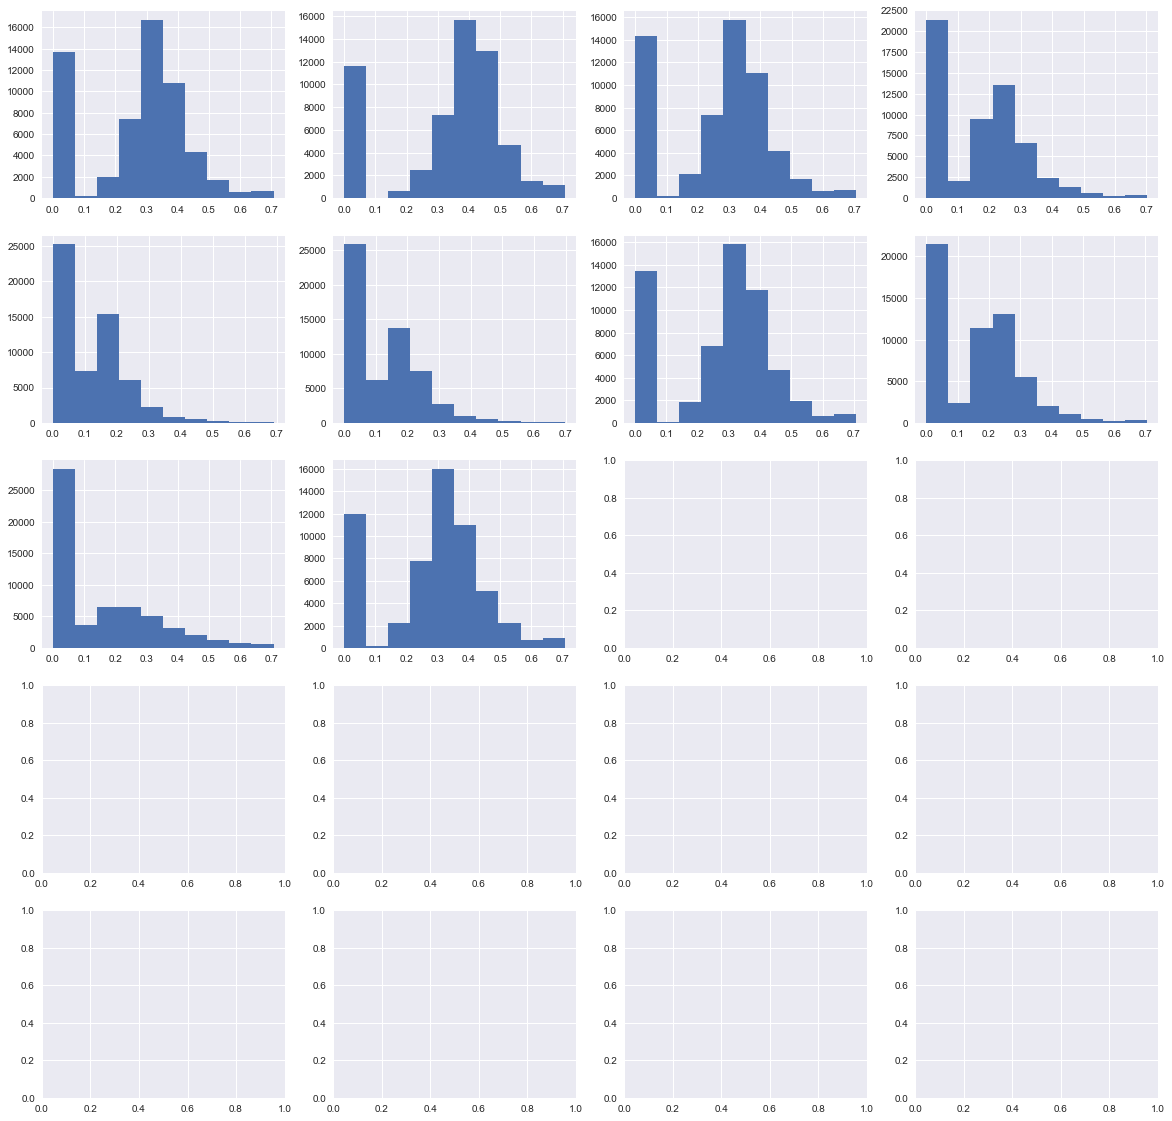

In [78]:
visualize_hist(out)

### Scale 1 to 5 to match survey

In [79]:
from sklearn.preprocessing import MinMaxScaler
mm_1_5 = MinMaxScaler((1, 5))
mm_log_out = pd.DataFrame(mm_1_5.fit_transform(out), columns = health_categories, index=out.index)

In [80]:
mm_log_out_a = pd.concat([mm_log_out, standardized_aliya.loc[mm_log_out.index, other_categories]], axis=1)
assert len(mm_log_out_a.columns) == len(standardized_aliya.columns)
assert len(mm_log_out_a) == len(mm_log_out)

In [81]:
mm_log_out.head(5)

,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Contains plastic
customer,,,,,,,,,,
77000001548,2.220152,2.774401,3.228952,1.715294,2.024853,1.880597,3.223240,2.962881,2.220152,2.638226
77000001680,2.662434,3.417868,2.951960,2.639690,1.884086,1.716192,3.211076,2.217409,2.109518,2.438544
77000002166,2.708316,3.054547,2.625417,2.379250,1.817820,1.904317,2.910788,2.578741,2.525019,2.947967
77000004744,2.384525,3.629949,3.110104,3.159294,1.454771,1.896563,3.063224,2.320064,3.018718,2.976957
77000005496,3.672307,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Choose the cluster centroids for the healthy and non-healthy cluster using prior opinion

In [82]:
from sklearn.cluster import KMeans
km = KMeans(2, init=np.array([[5, 5, 1, 5, 5, 1, 1, 1, 1, 1],
                              [1, 1, 5, 1, 1, 5, 5, 5, 5, 5]
    
]))
mm_log_out['labels'] = np.squeeze(km.fit_predict(mm_log_out))
mm_log_out['labels'].replace({1: "Healthy", 0: "Unhealthy"}, inplace=True)

C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\sklearn\cluster\k_means_.py:968: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [83]:
df_plot = pd.DataFrame({'Average Consumption':np.array(mm_log_out[health_categories]).reshape(-1), 
                        'Category':health_categories * len(mm_log_out),
                        'Label': np.repeat(mm_log_out['labels'], mm_log_out[health_categories].shape[1])})                 

C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


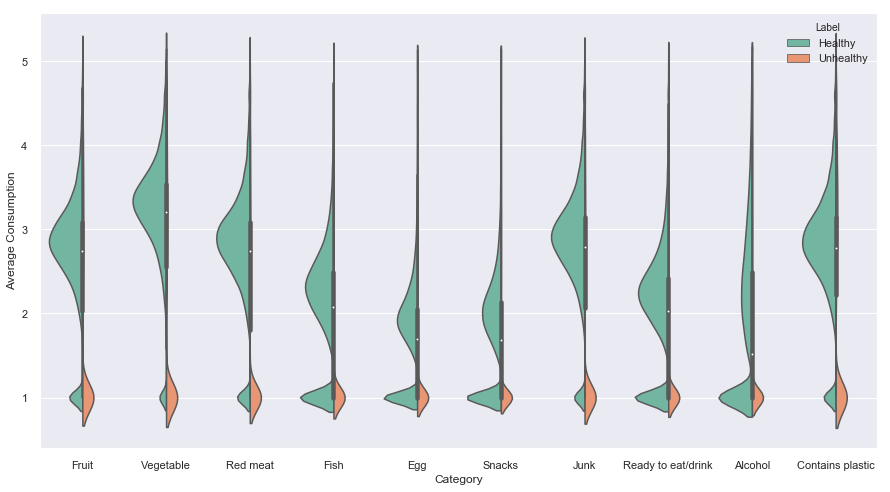

In [84]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.violinplot(x="Category", y="Average Consumption", hue="Label", data=df_plot, palette="Set2", split=True, scale="count")

C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


(<Figure size 1080x576 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1ab444bc5f8>])

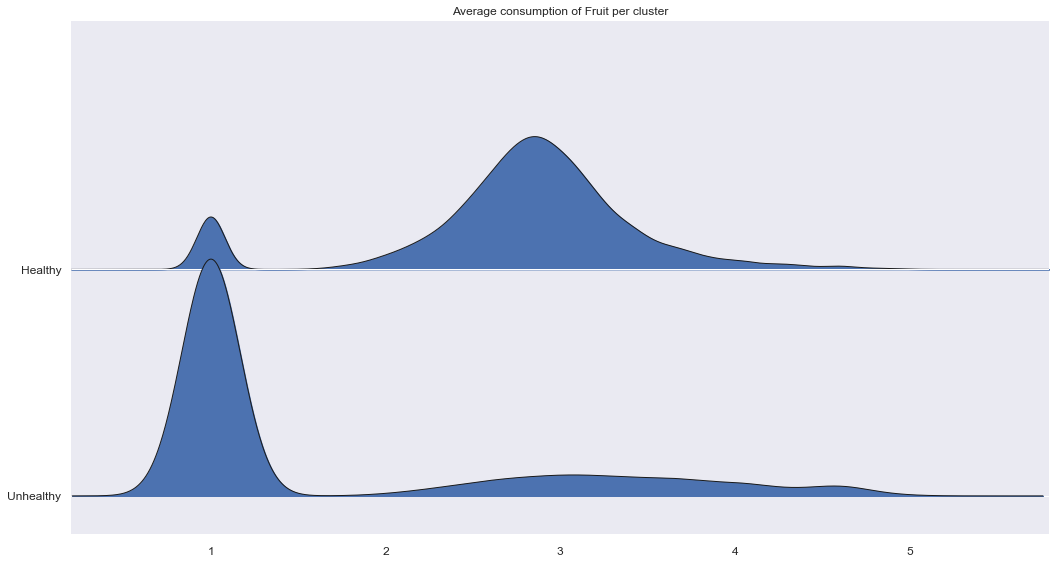

In [85]:
import joypy
fig, ax = plt.subplots(1,2)
joypy.joyplot(mm_log_out, by="labels", column="Fruit", range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title=f"Average consumption of Fruit per cluster", ax=ax[0])

In [86]:
mm_log_out.groupby('labels').mean()

,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Contains plastic
labels,,,,,,,,,,
Healthy,2.770676,3.245447,2.797389,2.136884,1.763082,1.818493,2.855255,2.098857,2.036986,2.809495
Unhealthy,1.676820,1.750114,1.523393,1.318454,1.264662,1.185319,1.561830,1.269385,1.210765,1.888202


### At this point we realize that, despite we used prior opinion to assign the cluster centroids, we are not satisfied with the result from using a clustering algorithm, as we see that the 'healthy' cluster consumes more fruit and vegetable buy also more junk food and ready-to-eat food which for sure doesn't identify the healthy cluster

### So we try a different approach to clustering, where we cluster in the 'health space' rather than in the 'category space'

### The objective is to split in two each category (e.g. fruit < 0.6 vs fruit > 0.6) such that the data points that fall in one group are as more healthy as possible wrt to the people that fall in the other group. If there was only one dimension (say fruit) this would be straightforward... but because now a person that eats a lot of fruit may also drink a lot of alcohol you are interested in looking for the "cutoff" such that the health score of the group is maximized when you look for the healthy people. More specifically, you wanna find the cutoffs such that the difference in health score between the two groups is maximized!

## Compute health score, associating weights to each of the variable

In [87]:
def assign_score(x, healthy, high):
    if high:
        if healthy:
            return 1.2* x
        else:               
            return 1.2 * x
    else:
        if healthy:
            return  0.8 * x
        else:               
            return - 0.8*x       
    
cutoffs = {'Fruit': [True, True], 'Vegetable': [True, True], 'Red meat': [False, False], 'Fish' : [True, False], 
           'Egg': [True, False], 'Snacks': [False, True], 'Junk': [False, True], 
           'Ready to eat/drink' : [False, False], 'Alcohol': [False, True], 'Contains plastic': [False, False]}

In [88]:
score = pd.DataFrame()
for cat in health_categories:
    score[cat] = mm_log_out[cat].apply(lambda x : assign_score(x, cutoffs[cat][0], cutoffs[cat][1]))

In [89]:
mm_log_out['Score'] = np.sum(score, axis=1)

In [90]:
mm_log_out['Score'].describe()

count    57993.000000
mean        10.969393
std          3.429343
min         -3.468517
25%          9.071414
50%         11.876049
75%         13.363985
max         22.066290
Name: Score, dtype: float64

In [91]:
mm_log_out.head(5)

,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Contains plastic,labels,Score
customer,,,,,,,,,,,,
77000001548,2.220152,2.774401,3.228952,1.715294,2.024853,1.880597,3.223240,2.962881,2.220152,2.638226,Healthy,10.710322
77000001680,2.662434,3.417868,2.951960,2.639690,1.884086,1.716192,3.211076,2.217409,2.109518,2.438544,Healthy,13.273195
77000002166,2.708316,3.054547,2.625417,2.379250,1.817820,1.904317,2.910788,2.578741,2.525019,2.947967,Healthy,12.559539
77000004744,2.384525,3.629949,3.110104,3.159294,1.454771,1.896563,3.063224,2.320064,3.018718,2.976957,Healthy,13.757125
77000005496,3.672307,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Unhealthy,8.406768


## Look for cutoffs that maximize the difference in health score between healthy and unhealthy - start only with fruit and vegetable for visualization purposes

### Define the function (to maximize) calculating the difference in health score between healthy and unhealthy given different cutoffs

In [92]:
def difference_in_health_score_to_maximize_vegfr(array_cutoffs):
    f, v = tuple(array_cutoffs)
    mean_healthy = np.mean(mm_log_out['Score'][(mm_log_out['Fruit'] > f) & (mm_log_out['Vegetable'] > v) 
                                              ])
    mean_unhealthy = np.mean(mm_log_out['Score'][(mm_log_out['Fruit'] < f) & (mm_log_out['Vegetable'] < v) 
                                              ])
    return mean_healthy - mean_unhealthy

In [93]:
score_difference_vegfr = []
for i in np.linspace(1, 5, 20):
    for j in np.linspace(1, 5, 20):
        score_difference_vegfr.append(difference_in_health_score_to_maximize_vegfr([i,j]))
    


## Plot the difference in health score given different cutoff levels

Text(0.5, 0, 'Difference in Health Score')

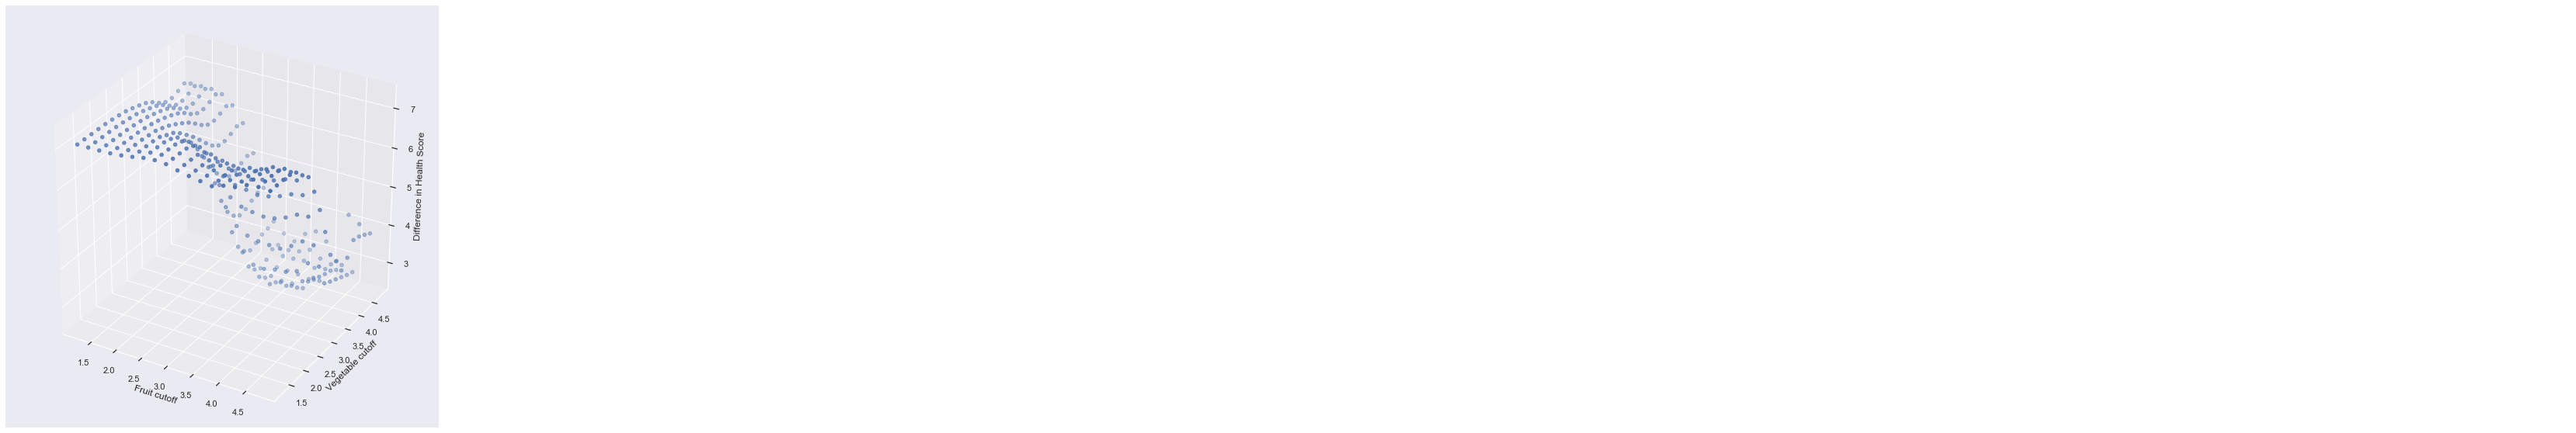

In [94]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=np.repeat(np.linspace(1, 5, 20), 20), 
               ys=list((np.linspace(1, 5, 20))) * 20, 
               zs=score_difference_vegfr, 
               zdir='z', s=20, c=None, depthshade=True)
ax.set_xlabel('Fruit cutoff')
ax.set_ylabel('Vegetable cutoff')
ax.set_zlabel('Difference in Health Score')


## We cannot minimize a discrete function, we need to smooth it (approximate it polynomial regression)

In [95]:
from sklearn.linear_model import LinearRegression
x1 = np.repeat(np.linspace(1, 5, 20), 20)
x2 = np.array(list((np.linspace(1, 5, 20))) * 20)
X = np.vstack((x1, x2, x1*x2, x1**2, x2**2, x2*x1**2, x1*x2**2)).T
y = np.array(score_difference_vegfr).reshape(-1, 1)
y[np.isnan(y)] = 0
ols = LinearRegression()
ols.fit(X, y)
print(pd.DataFrame({'Coefficient': [ols.intercept_[0]] + list(ols.coef_[0]), 
                    'Regressors': ['1', 'x1', 'x2', 'x1*x2', 'x1^2', 'x2^2', 'x2*x1^2', 'x1*x2^2']}))

   Coefficient Regressors
0   -10.722448          1
1     8.090725         x1
2     7.529832         x2
3    -1.961384      x1*x2
4    -1.178713       x1^2
5    -1.005226       x2^2
6     0.192048    x2*x1^2
7     0.094591    x1*x2^2


In [96]:
def smoothed_health_score_difference_vf(x):
    x1, x2 = x
    regressors = [1, x1, x2, x1*x2, x1**2, x2**2, x2*x1**2, x1*x2**2]
    return -np.dot(regressors, [ols.intercept_[0]] + list(ols.coef_[0]))

In [97]:
score_difference_smoothed = []
for i in np.linspace(1, 5, 20):
    for j in np.linspace(1, 5, 20):
        score_difference_smoothed.append(smoothed_health_score_difference_vf([i,j]))

## Minimize with Gradient Descent and find the optimal cutoff for fruit and vegetable

In [98]:
from scipy.optimize import minimize
sol = minimize(smoothed_health_score_difference_vf, 
               np.array([3.5,5]), 
               bounds = ((1,5),) * 2)

In [99]:
sol

      fun: -6.933641947516227
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.59872116e-06, -2.13162821e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([2.73204757, 2.41343236])

## Apply gradient descent also to other categories

In [100]:
def difference_in_health_score_to_maximize(array_cutoffs):
    f, v, sn, ju, al = tuple(array_cutoffs)
    mean_healthy = np.mean(mm_log_out['Score'][(mm_log_out['Red meat'] < f) & (mm_log_out['Fish'] > v) & 
                                               (mm_log_out['Alcohol'] < sn) & (mm_log_out['Snacks'] < ju) & 
                                               (mm_log_out['Junk'] < al)
                                              ])
    mean_unhealthy = np.mean(mm_log_out['Score'][~((mm_log_out['Red meat'] < f) & (mm_log_out['Fish'] > v) & 
                                               (mm_log_out['Alcohol'] < sn) & (mm_log_out['Snacks'] < ju) & 
                                               (mm_log_out['Junk'] < al))
                                              ])
    return mean_healthy - mean_unhealthy

### Evaluate n-dim discrete function

In [101]:
score_difference = []
xs = []
mini, maxi = 1, 5
for i in np.linspace(mini, maxi, 4):
    for j in np.linspace(mini, maxi, 3):
        for k in np.linspace(mini, maxi, 4):
            for l in np.linspace(mini, maxi, 3):
                for m in np.linspace(mini, maxi, 3):
                    xs.append([i,j,k,l,m])
                    score_difference.append(difference_in_health_score_to_maximize([i,j,k,l,m]))

### Smooth it

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
pl = PolynomialFeatures(3)
X = pl.fit_transform(np.array(xs))
y = np.array(score_difference).reshape(-1, 1)
y[np.isnan(y)] = 0
print(X.shape, y.shape)
ols = LinearRegression()
ols.fit(X, y)
print(pd.DataFrame({'Coefficient': [ols.intercept_[0]] + list(ols.coef_[0])}))

(432, 56) (432, 1)
     Coefficient
0  -7.528942e+09
1   1.397308e+06
2  -8.329685e-01
3   8.589006e+09
4  -6.253324e-01
5   3.262981e+09
6  -3.097518e+08
7   2.740166e-01
8  -1.063840e-01
9   4.133139e-02
10  8.520341e-02
11  2.990890e-02
12 -3.360915e+09
13 -2.003372e-02
14 -1.490587e-01
15 -3.049850e-02
16  1.805897e-01
17  5.906558e-02
18 -1.877904e-03
19 -1.276819e+09
20  2.828312e-02
21  1.212072e+08
22 -2.888346e-02
23  1.151586e-02
24 -7.574320e-03
25 -5.316496e-03
26 -7.687330e-03
27  3.050971e-02
28 -2.351379e-02
29 -1.752388e-02
30 -2.289140e-02
31  3.320158e-03
32  1.231360e-02
33  1.665330e-02
34 -8.613706e-03
35  1.132309e-02
36  5.002379e-03
37  3.734350e+08
38  2.536488e-02
39  2.821445e-02
40  2.870989e-02
41  3.477335e-03
42 -1.972198e-02
43 -2.505553e-02
44  1.841402e-02
45 -1.956463e-02
46  1.646042e-03
47 -2.288532e-02
48  3.394514e-03
49  1.619309e-03
50 -1.205945e-02
51  1.402533e-02
52  1.924038e-03
53  1.418687e+08
54 -9.840727e-03
55  6.442070e-03
56 -1.346747

In [103]:
def smoothed_health_score_difference(x):
    return -np.dot(pl.fit_transform(np.array(x).reshape(1, -1))[0], list(ols.coef_[0]))

## Apply GD to other categories

In [104]:
from scipy.optimize import minimize
sol = minimize(smoothed_health_score_difference, 
               np.array([3,3,3,3,3]), 
               bounds = ((1,5),) * 5)

In [105]:
sol

      fun: -9157134949.8944
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.        ,   0.        ,   0.        , 190.73486328,
       381.46972656])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 4
   status: 0
  success: True
        x: array([3.        , 1.84529944, 3.        , 1.8452994 , 4.1547008 ])

## Define final cutoffs

In [106]:
final_cutoff = {'Fruit':[2.73, True], 'Vegetable':[2.41, True], 'Snacks':[1.84, False], 'Junk':[4.15, False], 
                'Alcohol':[3, False], 
                'Red meat':[3, False], 'Fish':[1.84, True]}

## Divide dataset in Healthy vs Unhealthy with outcome cutoffs from GD

In [107]:
def healthy_assignment(x, final_cutoff):
    for category in final_cutoff:
        if final_cutoff[category][1]:
            if x[category] > final_cutoff[category][0]:
                continue
            else:
                return 0
        else:
            if x[category] < final_cutoff[category][0]:
                continue
            else:
                return 0
    return 1
            


In [108]:
mm_log_out_a['Healthy'] = mm_log_out_a.apply(lambda x: healthy_assignment(x, final_cutoff), axis=1)

In [109]:
np.sum(mm_log_out_a['Healthy'] == 1)

4877

## Proportion of Healthy people

In [110]:
np.sum(mm_log_out_a['Healthy'] == 1) / len(mm_log_out_a)

0.08409635645681375

In [111]:
mm_log_out_a.to_csv("C:/Users/Pc_User/Desktop/H-Farm/aliya_healthy.csv")

In [112]:
df = mm_log_out
df.head(5)

,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Contains plastic,labels,Score
customer,,,,,,,,,,,,
77000001548,2.220152,2.774401,3.228952,1.715294,2.024853,1.880597,3.223240,2.962881,2.220152,2.638226,Healthy,10.710322
77000001680,2.662434,3.417868,2.951960,2.639690,1.884086,1.716192,3.211076,2.217409,2.109518,2.438544,Healthy,13.273195
77000002166,2.708316,3.054547,2.625417,2.379250,1.817820,1.904317,2.910788,2.578741,2.525019,2.947967,Healthy,12.559539
77000004744,2.384525,3.629949,3.110104,3.159294,1.454771,1.896563,3.063224,2.320064,3.018718,2.976957,Healthy,13.757125
77000005496,3.672307,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Unhealthy,8.406768


In [113]:
df.to_csv("C:/Users/Pc_User/Desktop/H-Farm/predict_likelihood_v5.csv")